In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


### Create dataset directory

In [ ]:
train_dataset = '/content/gdrive/MyDrive/CarDamage/dataset/train.csv'
val_dataset = '/content/gdrive/MyDrive/CarDamage/dataset/val.csv'
test_dataset = '/content/gdrive/MyDrive/CarDamage/dataset/test.csv'

train_images = '/content/gdrive/MyDrive/CarDamage/dataset/images/train/'
val_images = '/content/gdrive/MyDrive/CarDamage/dataset/images/val/'
test_images = '/content/gdrive/MyDrive/CarDamage/dataset/images/test/'

In [ ]:
%%bash
mkdir /content/train
mkdir /content/val
mkdir /content/test

mkdir /content/train/crack
mkdir /content/train/dent
mkdir '/content/train/glass shatter'
mkdir '/content/train/lamp broken'
mkdir /content/train/scratch
mkdir '/content/train/tire flat'

mkdir /content/val/crack
mkdir /content/val/dent
mkdir '/content/val/glass shatter'
mkdir '/content/val/lamp broken'
mkdir /content/val/scratch
mkdir '/content/val/tire flat'

mkdir /content/test/crack
mkdir /content/test/dent
mkdir '/content/test/glass shatter'
mkdir '/content/test/lamp broken'
mkdir /content/test/scratch
mkdir '/content/test/tire flat'


In [ ]:
def create_directory_dataset(df, img_path, subset):
  counter = 1
  for _,j in df.iterrows():
    img = cv2.imread(img_path+j['filename'])
    cropped_img = img[j['ymin']:j['ymax'],
                      j['xmin']:j['xmax']]
    class_name = j['class']
    cv2.imwrite(f'/content/{subset}/{class_name}/{counter}.png', cropped_img)
    counter += 1

In [ ]:
train_df = pd.read_csv(train_dataset)
val_df = pd.read_csv(val_dataset)
test_df = pd.read_csv(test_dataset)

create_directory_dataset(train_df, train_images, 'train')
create_directory_dataset(val_df, val_images, 'val')
create_directory_dataset(test_df, test_images, 'test')

In [ ]:
!cp -r /content/train /content/gdrive/MyDrive/car_images
!cp -r /content/val /content/gdrive/MyDrive/car_images
!cp -r /content/test /content/gdrive/MyDrive/car_images

In [ ]:
print("In training data - ")
!ls /content/train/crack | wc -l
!ls /content/train/dent | wc -l
!ls '/content/train/glass shatter' | wc -l
!ls '/content/train/lamp broken' | wc -l
!ls /content/train/scratch | wc -l
!ls '/content/train/tire flat' | wc -l

print("In validation data - ")
!ls /content/val/crack | wc -l
!ls /content/val/dent | wc -l
!ls '/content/val/glass shatter' | wc -l
!ls '/content/val/lamp broken' | wc -l
!ls /content/val/scratch | wc -l
!ls '/content/val/tire flat' | wc -l

print("In testing data - ")
!ls /content/test/crack | wc -l
!ls /content/test/dent | wc -l
!ls '/content/test/glass shatter' | wc -l
!ls '/content/test/lamp broken' | wc -l
!ls /content/test/scratch | wc -l
!ls '/content/test/tire flat' | wc -l

In training data - 
807
2187
671
560
3351
253
In validation data - 
216
632
196
164
1013
63
In testing data - 
119
350
79
84
524
28


### Data generator

In [ ]:
!cp -r '/content/gdrive/MyDrive/car_images/train' /content/
!cp -r '/content/gdrive/MyDrive/car_images/val' /content/
!cp -r '/content/gdrive/MyDrive/car_images/test' /content/

In [ ]:
train_images = '/content/train'
val_images = '/content/val'
test_images = '/content/test'

In [ ]:
IMAGE_SIZE = (64,64)
BATCH_SIZE = 64

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_images,
                                             shuffle=True,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(val_images,
                                             shuffle=True,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

Found 7829 files belonging to 6 classes.
Found 2284 files belonging to 6 classes.


In [ ]:
class_names = val_dataset.class_names

In [ ]:
# some images
sample_batch = next(train_generator)
plt.figure(figsize=(10, 10))
for i, row in sample_batch:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print(train_generator.class_indices)

{'crack': 0, 'dent': 1, 'glass shatter': 2, 'lamp broken': 3, 'scratch': 4, 'tire flat': 5}


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Model Architecture

In [ ]:
input_image_shape = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=input_image_shape,
                                               include_top=False,
                                               alpha=0.35,
                                               weights='imagenet')

base_model.summary()

2019640/2019640 [==============================] - 1s 0us/step
Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 32, 16)           432       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 32, 32, 16)           64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [ ]:
base_model.trainable = False
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
linear_dense_layer1 = tf.keras.layers.Dense(256, activation='relu')
# linear_dense_layer2 = tf.keras.layers.Dense(128, activation='relu')
prediction_layer = tf.keras.layers.Dense(6, activation='softmax')


In [ ]:
inputs = tf.keras.Input(shape=input_image_shape)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = linear_dense_layer1(x)
x = tf.keras.layers.Dropout(0.1)(x)
# x = linear_dense_layer2(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 64, 64, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 64, 64, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_0.35_224 (Func  (None, 2, 2, 1280)        410208    
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

### Train the model

In [ ]:
loss0, accuracy0 = model.evaluate(val_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

36/36 [==============================] - 10s 155ms/step - loss: 2.1374 - accuracy: 0.2364
initial loss: 2.14
initial accuracy: 0.24


In [ ]:
EPOCHS = 12
training_history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset)


Epoch 1/12
123/123 [==============================] - 35s 256ms/step - loss: 1.1673 - accuracy: 0.5776 - val_loss: 0.8366 - val_accuracy: 0.6848
Epoch 2/12
123/123 [==============================] - 32s 252ms/step - loss: 0.7891 - accuracy: 0.7009 - val_loss: 0.7382 - val_accuracy: 0.7207
Epoch 3/12
123/123 [==============================] - 35s 278ms/step - loss: 0.6892 - accuracy: 0.7390 - val_loss: 0.7018 - val_accuracy: 0.7320
Epoch 4/12
123/123 [==============================] - 35s 274ms/step - loss: 0.6239 - accuracy: 0.7601 - val_loss: 0.6815 - val_accuracy: 0.7408
Epoch 5/12
123/123 [==============================] - 44s 354ms/step - loss: 0.5769 - accuracy: 0.7757 - val_loss: 0.6675 - val_accuracy: 0.7412
Epoch 6/12
123/123 [==============================] - 38s 300ms/step - loss: 0.5429 - accuracy: 0.7899 - val_loss: 0.6578 - val_accuracy: 0.7434
Epoch 7/12
123/123 [==============================] - 33s 261ms/step - loss: 0.5053 - accuracy: 0.8098 - val_loss: 0.6495 - val_ac

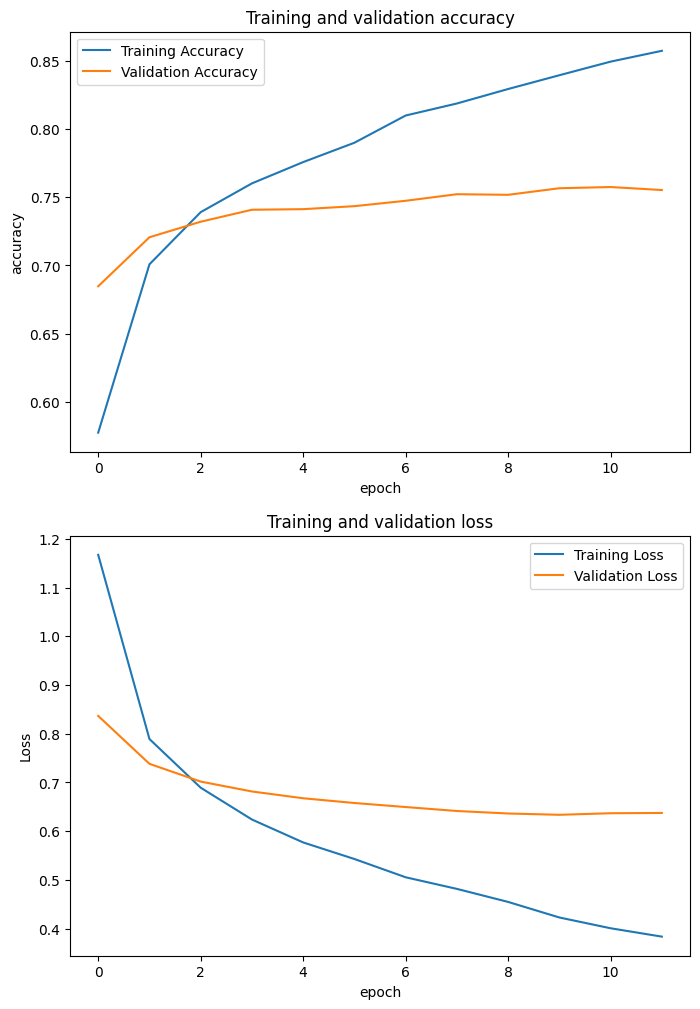

In [ ]:
# TODO: Plot train and test accuracies vs Epochs
val_accuracy = training_history.history['val_accuracy']
train_accuracy = training_history.history['accuracy']
val_loss = training_history.history['val_loss']
train_loss = training_history.history['loss']

plt.figure(figsize=(8, 12))

plt.subplot(2, 1, 1)
# plotting the loss graph
plt.plot(train_accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("Training and validation accuracy")

plt.subplot(2, 1, 2)
# plotting the loss graph
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_images,
                                             shuffle=True,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

loss,accuracy = model.evaluate(test_dataset)

Found 1184 files belonging to 6 classes.
19/19 [==============================] - 5s 216ms/step - loss: 0.6504 - accuracy: 0.7517


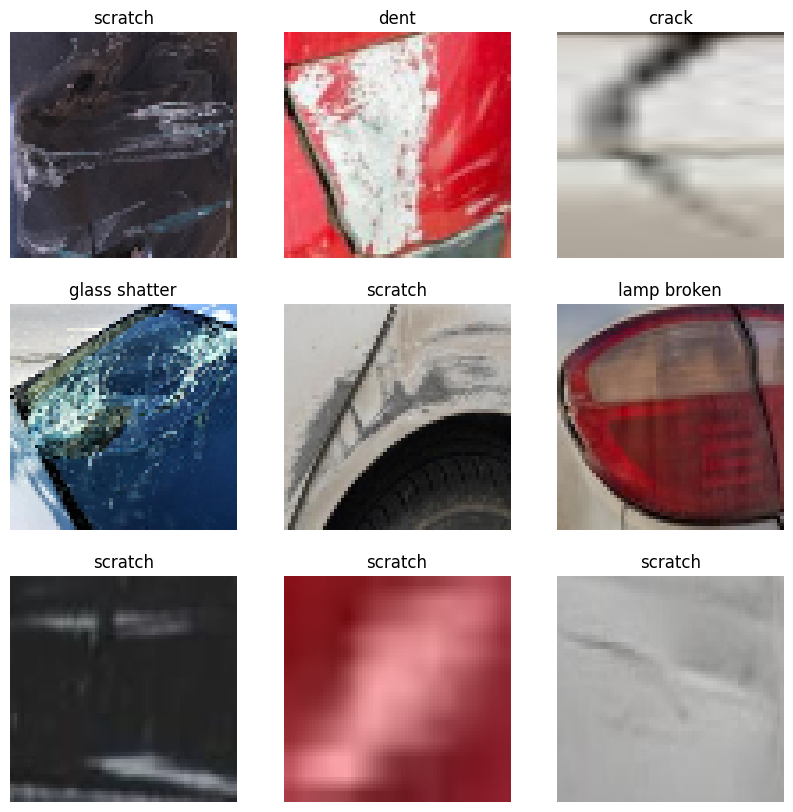

In [ ]:
class_names = ['crack', 'dent', 'glass shatter', 'lamp broken', 'scratch', 'tire flat']
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
# print(predictions)

# print (predictions[:10]) # logit
# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# print (predictions[:10])
predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))

  for m,n in enumerate(predictions[i]):
    if n == 1:
      j = m
      break
  temp = predictions[i]
  # print(temp)
  # print(j)
  plt.title(class_names[j])
  plt.axis("off")

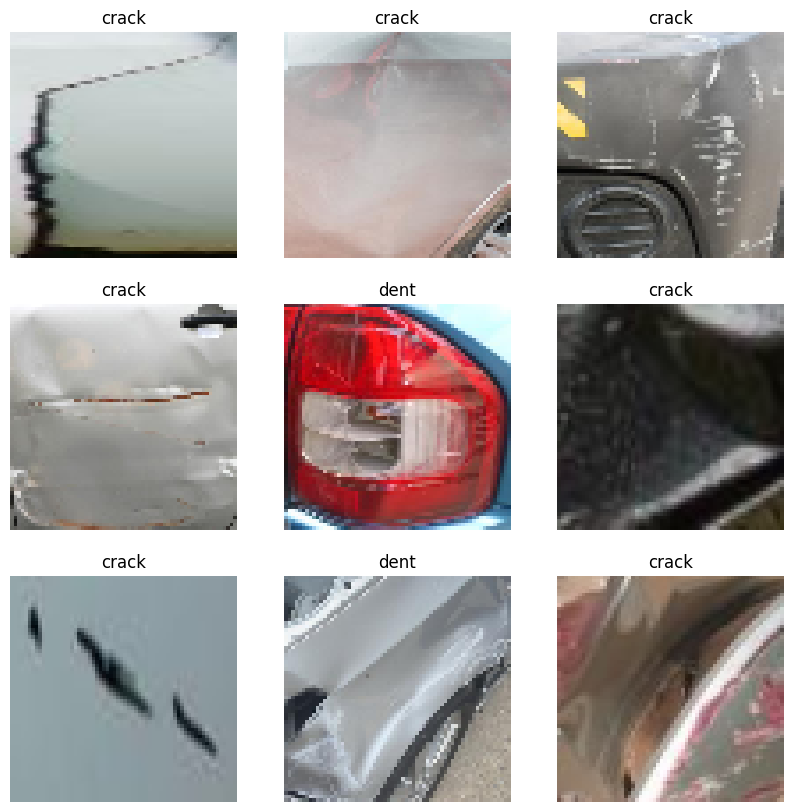

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# print(predictions)
# print (predictions[:10]) # logit
predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Convert the model to tflite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # dynamic range quantization. size reduction but computing is done in fp32
tflite_model = converter.convert()

import pathlib
tflite_model_file = pathlib.Path('/content/model-float32.tflite')
model_size = tflite_model_file.write_bytes(tflite_model)
print(f"Model size - {model_size} bytes")

Model size - 878560 bytes


### Post-training quantization

In [ ]:
tflite32_model = '/content/model-float32.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_get():
    for input_value, _ in val_dataset.take(100):
        yield [input_value]

converter.representative_dataset = representative_data_get
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model_quant = converter.convert()
tflite_model_quant_file = pathlib.Path('/content/model-int8.tflite')
tflite_model_quant_file.write_bytes(tflite_model_quant)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


953360

### Save the model as .cc

In [ ]:
model_file = 'model-int8'
!xxd -i /content/{model_file}.tflite | sed "s/unsigned/const unsigned/g" | sed "s/model_model_int8_tflite/gmodel/g"> /content/model.cc


## Rough Work

In [ ]:
# data_generator = ImageDataGenerator(
#     rescale=1./255,
# )

# print("For train dataset - ")
# train_generator = data_generator.flow_from_dataframe(
#     dataframe = train_df,
#     directory = train_images,
#     x_col = 'filename',
#     y_col = 'class',
#     target_size = IMAGE_SIZE,
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical',
#     shuffle = True,
# )
# print("For val dataset - ")
# val_generator = data_generator.flow_from_dataframe(
#     dataframe = val_df,
#     directory = val_images,
#     x_col = 'filename',
#     y_col = 'class',
#     target_size = IMAGE_SIZE,
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical',
#     shuffle = True,
# )

# print("For test dataset - ")
# test_generator = data_generator.flow_from_dataframe(
#     dataframe = test_df,
#     directory = test_images,
#     x_col = 'filename',
#     y_col = 'class',
#     target_size = IMAGE_SIZE,
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical',
#     shuffle = True,
# )

In [ ]:
# def calculate_bbox_area(xmin, ymin, xmax, ymax):
#   a = abs(abs(xmax)-abs(xmin))
#   b = abs(abs(ymax)-abs(ymin))
#   c = a*b
#   return c

# def transform_data_for_classification(df):
#   filename = []
#   classname = []
#   grouped_df = df.groupby('filename')

#   for group, data in grouped_df:
#     max_area = 0
#     for _,i in data.iterrows():
#       area = calculate_bbox_area(i['xmin'], i['ymin'], i['xmax'], i['ymax'])
#       if area>max_area:
#         class_to_append = i['class']
#     filename.append(group)
#     classname.append(class_to_append)

#   temp_dict = {'filename':filename, 'class':classname}
#   df = pd.DataFrame(temp_dict)
#   return df

# train_df = transform_data_for_classification(train_df)
# val_df = transform_data_for_classification(val_df)
# test_df = transform_data_for_classification(test_df)